# Hand-in 3, Part 2: Data Modeling

In this part you will take the csv file "reduced_field_data.csv" from Part 1, and use it to estimate the line criticality indices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Score function

Below is a scoring function we have written for you. The output of this function is a score of how well your procedure is doing. Higher scores are worse!

As you can see, it penalizes heavily when you don't predict accurately values when they are being overloaded, i.e. false negatives.


In [39]:
def score_func(y_est, y_real):
    """
        This function takes your estimates y_est and
        scores them against the real data y_real.
        You should use this function to show how good your estimation method is.
    """
    # Square deviation
    sqr_err = np.sum(((y_est - y_real)**2).sum())
    # Penalty for not estimating a critical value above 0.95 when it occurs.
    false_negative = np.sum(np.where(np.logical_and(y_est < 0.95, y_real > 0.95), 10*np.sqrt(np.abs((y_est - y_real))), 0).sum())
    return sqr_err + false_negative

## Load and clean data

Load your data from the previous exercise as well as the criticality data.


In [3]:
# Data is loaded here
field_data = pd.read_csv("reduced_field_data.csv", index_col=0)
crit_data = pd.read_csv("flow_criticality_data.csv", index_col=0)

crit_data.head()

,flow_89_94,flow_20_23,flow_49_64,flow_101_532,flow_26_28,flow_172_176,flow_122_130,flow_105_116,flow_193_194,flow_187_191
Time,,,,,,,,,,
2012-01-01 00:00:00,0.296633,0.144482,0.341926,0.429794,0.107191,0.501129,0.954522,0.157365,0.555081,0.215995
2012-01-01 01:00:00,0.286880,0.140814,0.345723,0.435347,0.109399,0.484324,0.957007,0.168160,0.526282,0.161886
2012-01-01 02:00:00,0.221261,0.139097,0.329172,0.402732,0.258004,0.473216,0.964564,0.151398,0.512717,0.114494
2012-01-01 03:00:00,0.139193,0.159584,0.322661,0.380344,0.298660,0.416357,0.756591,0.061982,0.518129,0.078985
2012-01-01 04:00:00,0.090387,0.167504,0.288663,0.314070,0.287543,0.399404,0.724427,0.063575,0.515229,0.062350


## Linear regression

We have implemented a simple linear regression to apply to your data.
You should use this as a benchmark for your neural network below.


In [4]:
#Because the two dataframes is not the same length
crit_data2 = crit_data[crit_data.index.isin(field_data['time'])].dropna(axis=0)
print("Crit_data shape:",crit_data2.shape)
print("Crit_data2 shape:",crit_data.shape)
print("Field_data shape:",field_data.shape)

field_data = field_data.drop('time',1)

print("The shapes now fit")



Crit_data shape: (8311, 10)
Crit_data2 shape: (8784, 10)
Field_data shape: (8311, 22)
The shapes now fit


Overall error: 26066.7537


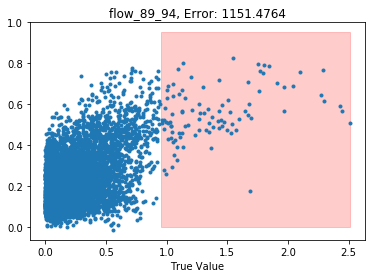

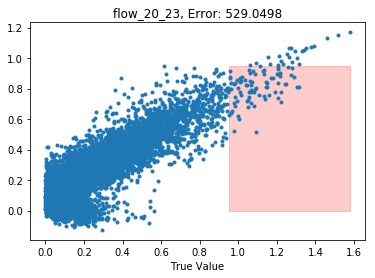

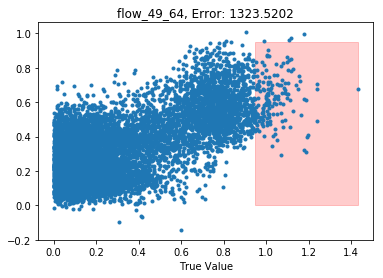

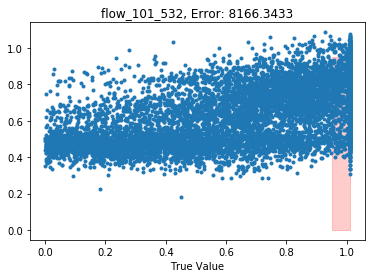

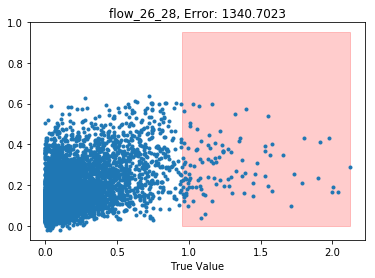

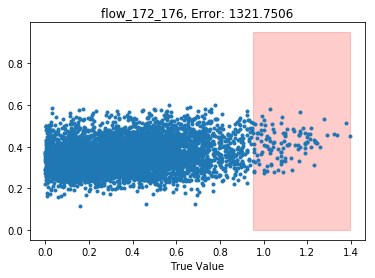

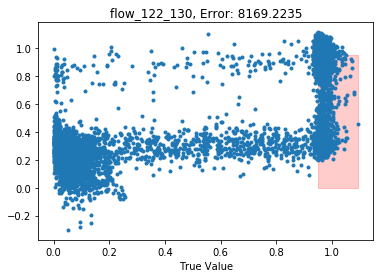

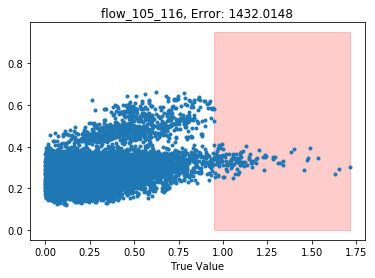

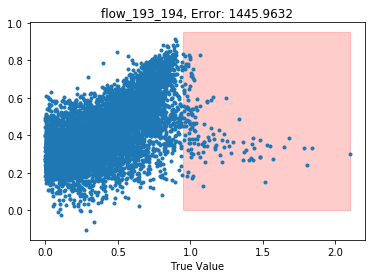

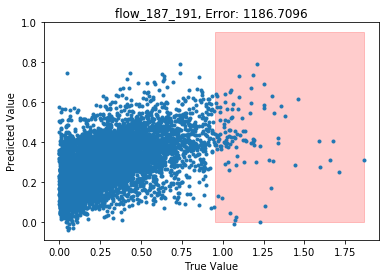

In [5]:
# The code below implements a linear regression on your data and compares predicted and true values.
# On the plots there is a red square indicating the areas corresponding to false negatives.
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(field_data,crit_data2)

y_pred = lm.predict(field_data)
for index in range(10):
    plt.figure()
    plt.fill_between([0.95, crit_data2.iloc[:,index].max()], [0.95, 0.95], color='r', alpha=0.2)
    plt.plot(crit_data2.iloc[:,index],y_pred[:,index],'.')
    error = score_func(y_pred[:,index],crit_data2.iloc[:,index])
    plt.title('{0}, Error: {1:.04f}'.format(crit_data2.columns[index], error))
    plt.xlabel('True Value')

plt.ylabel('Predicted Value')
print('Overall error: {0:.04f}'.format(score_func(y_pred, crit_data2)))


**Q#6** Would you recommend using Linear Regression for estimating line criticality indices? Why/why not?


No!   Linear regression is kinda the default regression. It should be used as a baseline to compare the real model to. In some ideal cases linear regression might be the best, but if you are working with real-world data it is uncommon.  

# Neural Network

You should now produce a neural network that can estimate criticality indices.
Split your data into a training and test set, build your neural network below, and use the score_func defined above to estimate your model quality.

**Q#7** Explain why you chose the layers, nodes and activation functions you did. (No wrong answers, we want to know your thought process!) What is the best score you can get with a single layer?

You asked for a linear regression, so i only added 1 layer with the activation type 'linear'. I chose Dense(10) because it didn't work otherwise.  

loss funcion 'mean squared error' : because outliers count a lot. 

19573.7718143 is the lowest seen score from the score_func


In [6]:
# Split data into training and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(field_data,
                                                    crit_data2, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [40]:
#INSERT Neural Network Code here for a linear regression.

# Remember to import the kind of layers you want from the keras library.
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import losses


listOfErrors1 = list()

#for i in range(0,30):
model = Sequential()
model.add(Dense(10, input_shape=(21,)))
model.add(Activation('linear'))

adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam)
history1=model.fit(x_train.values,y_train.values, epochs = 10, batch_size=500, shuffle=False)
y_pred1 = model.predict(x_test.values, batch_size = 1000)
listOfErrors1.append(history1.history['loss'][-1])
    
#plt.hist(listOfErrors1)
#plt.grid(True)
#plt.show()

print(score_func(y_pred1, y_test))



Epoch 1/10
6233/6233 [==============================] - 0s - loss: 56517.7248     
Epoch 2/10
6233/6233 [==============================] - 0s - loss: 10883.5732     
Epoch 3/10
6233/6233 [==============================] - 0s - loss: 2633.8777     
Epoch 4/10
6233/6233 [==============================] - 0s - loss: 875.5812      
Epoch 5/10
6233/6233 [==============================] - 0s - loss: 279.9594     
Epoch 6/10
6233/6233 [==============================] - 0s - loss: 94.6588      
Epoch 7/10
6233/6233 [==============================] - 0s - loss: 39.7125     
Epoch 8/10
6233/6233 [==============================] - 0s - loss: 20.4207     
Epoch 9/10
6233/6233 [==============================] - 0s - loss: 11.9937     
Epoch 10/10
6233/6233 [==============================] - 0s - loss: 7.7090     
124897.015085


# K-fold cross validation

To ensure that your neural network actually works when presented with new data, take the neural network you defined above, and perform a k-fold cross validation on it.

**Q#8** Using a test window size of one tenth of your data (ten-fold cross validation), plot a histogram of the output of score_func for the validation. Tweak your neural network to achieve the lowest mean score.H




In [51]:
# Your k-fold code goes here.
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors2 = list()


kf1 = KFold(n_splits=10,shuffle=True)
print(kf1)
for train_index, test_index in kf1.split(field_data):
    X_train, X_test = field_data.iloc[train_index], field_data.iloc[test_index]
    Y_train, Y_test = crit_data2.iloc[train_index], crit_data2.iloc[test_index]
    #print(X_test)
    model = Sequential()
    model.add(Dense(10, input_shape=(21,)))
    model.add(Activation('linear'))
    model.add(Convolutional(10, input_shape=(21,)))
    model.add(Activation('linear'))

    adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history1=model.fit(x_train.values,y_train.values, epochs = 20, batch_size=500, shuffle=False)
    y_pred2 = model.predict(x_test.values, batch_size = 1000)
    listOfErrors2.append(score_func(y_pred2, y_test))
    
plt.hist(listOfErrors2)
plt.grid(True)
plt.show()

print("mean score: ",np.mean(listOfErrors2))

KFold(n_splits=10, random_state=None, shuffle=True)


NameError: name 'Convolutional' is not defined

In [49]:
listOfErrors2

[289363.53667997121,
 26991.959919958546,
 451819.45961267245,
 15784.237108569268,
 14580.73057400948,
 10334.053511051239,
 20640.160731051954,
 10944.767977170308,
 22698.334099769861,
 16732.264884970762]

**Q#9** Are you satisfied with the quality of the final estimator? What would be your recommendation for your boss on this issue?

# Extra task for 3-person groups

**Q#10** Repeat the process, once reducing to 15 sensors, and once reducing to 25 sensors. The costs to keep these sensors running is directly proportional to the number of sensors used. Does changing the number of sensors used change your conclusion in Q#9?